##Overview

In this notebook we prepare the datasets for the ranking model, which is the second stage in the YouTube recommendation system.\
After we retrieve the candidates for viewing from the candidates model, we now want to learn the best recommendation out od the candidates, given additional data on each candidate movie.\
The additional file in the items content file includes:
1. The movie release year
2. The movie classification to genres
3. Movie title, which we do not use.

Each sample of the ranking model will combine the viewing histoy (as in the candidates model) with the candidate additional data. The user data is no longer used.

Processing details:
- We normalize the release year, as suggested in the paper, by dividing the years into 10 quantiles of the cumulative distribution. the square and square-root of the results are also added.
- For each candidate, we calculate the mean rating by all users who rated it as another feature. This is assumed to be a feature which is also available in the YouTube scenario, where the percent of watch time can be calculated for each video.
- We need to split the candidates lists into individual samples for evaluation in ranking. We extract 100 candidates for each sample in the original dataset.This would theoretically give 6040X50X100 = 30,200,000samples. Because of the huge numbers, we use one original sample per user (The last in the dataset). Candidates are matched to their right information from the previous movies that were used to predict them.
- To each candidate we add two labels:
  1. If it was viewed by the user, it will be labeled 1, otherwise 0.
  2. Another lable is the rating it got, if viewed. If the movie was not viewed, we still label the rating as 1, in order to learn the expected rating, similarly to the optimization over expected watch time described in the paper.


**Imports and administration**

In [1]:
# basic
import os 
import sys
from time import time
import zipfile
import requests
import pickle
import gdown
!pip install --upgrade --no-cache-dir gdown

# general
import warnings
import numpy as np
import pandas as pd

# visual
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

# notebook
from IPython.display import display, HTML
from tqdm import tqdm
import copy


# torch
import torch
from torch import nn
import torch.nn.functional as F
from torch.nn import Sequential
from torch.nn import Sigmoid,ReLU
from torch.nn import Embedding,Linear,Dropout
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToTensor,Compose
from torch.optim import SparseAdam,Adam,Adagrad,SGD

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
warnings.filterwarnings('ignore')

**Download data**

In [ ]:
url = 'http://files.grouplens.org/datasets/movielens/ml-1m.zip'
zip_name = 'ml-1m.zip'
data_dir = 'ml-1m/'

r = requests.get(url, allow_redirects=True)
open(zip_name, 'wb').write(r.content)

with zipfile.ZipFile(zip_name,"r") as zip_ref:
    zip_ref.extractall()

**Read main ratings file**

In [ ]:
cols_data = ['user_id','item_id','rating','timestamp']
df_ratings = pd.read_csv(data_dir + 'ratings.dat',delimiter='::', header=None,names=cols_data)
# df_ratings.shape

n_full_samples = df_ratings.shape[0]
unique_users_test = df_ratings['user_id'].nunique()
n_items = df_ratings['item_id'].max() + 1 #starts at 1
print(f'There are a total of {n_full_samples} samples in the full dataset, belonging to {unique_users_test} distinct users')

There are a total of 1000209 samples in the full dataset, belonging to 6040 distinct users


In [ ]:
n_items

3953

In [ ]:
# #Here, we download the original dataframes with samples for the candidate model, containing the list of previous watches
# path = './drive/My Drive/Colab Notebooks/recsys_final_project/save_for_ranking_data'
# with open(path , 'rb') as f:
#   (df_test, df_val, df_features_sampled) = pickle.load(f)
#   print('loaded dataframes')

loaded dataframes


In [2]:
# #Here, we download the original dataframes with samples for the candidate model, containing the list of previous watches
url = "https://drive.google.com/file/d/1bbeVBJig-V6j4F1EfRXaT-5338-lkCFY/view?usp=sharing"
data_from_candidates_path = 'candidates_data'
gdown.download(url, data_from_candidates_path, quiet=False,fuzzy=True)

# path = './drive/My Drive/Colab Notebooks/recsys_final_project/save_for_ranking_data'
with open(data_from_candidates_path , 'rb') as f:
  (df_test, df_val, df_features_sampled) = pickle.load(f)
  print('loaded dataframes')


Downloading...
From: https://drive.google.com/uc?id=1bbeVBJig-V6j4F1EfRXaT-5338-lkCFY
To: /content/candidates_data
100%|██████████| 126M/126M [00:02<00:00, 58.2MB/s]


loaded dataframes


###Item data

In [ ]:
cols_item = ['movie id', 'movie name', 'genres']             
df_items = pd.read_csv(data_dir + 'movies.dat', delimiter='::', header=None, names=cols_item, encoding = 'ISO-8859-1')
df_items.shape

(3883, 3)

In [ ]:
df_items.head()

,movie id,movie name,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
def separate_year(name_year):
  date = name_year.split('(')[-1]
  return int(date[:-1])

In [ ]:
year = df_items['movie name'].apply(separate_year)
# sum(year.isna()) # = 0 so no missing years

**Normallize year feature according to quantiles of the distribution, as in the paper.\
We first find the quantiles, build the bins, and map each year to its quantile.\
Additional powers of year are added as well as in the paper. sqrt and sqr.**

In [ ]:
q = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
quantiles = np.quantile(year, q)

In [ ]:
year_bins = np.concatenate((np.expand_dims(year.min(), axis = 0),quantiles, np.expand_dims(year.max(), axis = 0)))
year_bins

array([1919., 1959., 1977., 1986., 1991., 1994., 1995., 1996., 1997.,
       1999., 2000.])

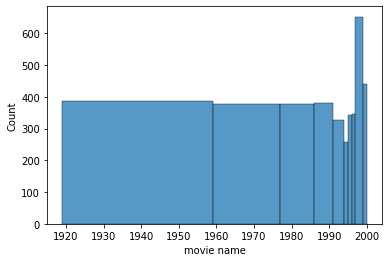

In [ ]:
# We confirm that we got the bins right by plotting the distribution, flattened to quantiles
# There is a known anomaly of many "new" movies, but there we can't separate further.
sns.histplot(data=year, bins = year_bins)

In [ ]:
def year_to_quantile(year, year_bins):
  quant = np.array([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
  for start, end, q in zip(year_bins[:-1], year_bins[1:], quant):
    if year >= start and year <= end:
      return q

In [ ]:
df_items['year'] = year
df_items['normalized year'] = df_items['year'].apply(lambda x: year_to_quantile(x, year_bins))
df_items['normalized year sqrt'] = df_items['normalized year'].apply(lambda x: x**0.5)
df_items['normalized year sqr'] = df_items['normalized year'].apply(lambda x: x**2)

In [ ]:
#Alternative regular normalization
# df_items['year'] = year
# #some normalization:
# max_year = df_items['year'].max()
# year_range = max_year - df_items['year'].min()
# df_items['normalized year'] = (max_year - df_items['year'])/year_range
# df_items['normalized year sqrt'] = df_items['normalized year'].apply(lambda x: x**0.5)
# df_items['normalized year sqr'] = df_items['normalized year'].apply(lambda x: x**2)

**Genres**

In [ ]:
genres_list = ['Action','Adventure','Animation','Children\'s','Comedy','Crime','Documentary','Drama','Fantasy','Film-Noir','Horror','Musical','Mystery','Romance','Sci-Fi','Thriller','War','Western']
genres_mapping = dict(zip(genres_list, np.arange(len(genres_list))))

In [ ]:
def separate_genres(genres):
  item_genres = genres.split('|')
  genres_features = np.zeros(len(genres_list))
  for g in item_genres:
    genres_features[genres_mapping[g]] = 1
  return genres_features

In [ ]:
g_features = df_items['genres'].apply(separate_genres)

In [ ]:
g_features.head()

0    [0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...
1    [0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...
2    [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...
3    [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, ...
4    [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...
Name: genres, dtype: object

In [ ]:
df_items['genres features'] = g_features

In [ ]:
df_items.head()

,movie id,movie name,genres,year,normalized year,normalized year sqrt,normalized year sqr,genres features
0,1,Toy Story (1995),Animation|Children's|Comedy,1995,0.5,0.707107,0.25,"[0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
1,2,Jumanji (1995),Adventure|Children's|Fantasy,1995,0.5,0.707107,0.25,"[0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, ..."
2,3,Grumpier Old Men (1995),Comedy|Romance,1995,0.5,0.707107,0.25,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
3,4,Waiting to Exhale (1995),Comedy|Drama,1995,0.5,0.707107,0.25,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, ..."
4,5,Father of the Bride Part II (1995),Comedy,1995,0.5,0.707107,0.25,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."


###Merging with candidates data

In [ ]:
path = './drive/My Drive/Colab Notebooks/recsys_final_project/candidates_3'
with open(path , 'rb') as f:
  (train_candidates, all_test_candidates, all_validation_candidates) = pickle.load(f)
  print('loaded candidates')

loaded candidates


In [ ]:
n_candidates = 100

In [ ]:
# all_validation_candidates.shape
train_candidates.shape

(6040, 250)

In [ ]:
# Generate ratings dataframe to easily extract user-item ratings
ratings = df_ratings.pivot(index = 'user_id', columns ='item_id', values = 'rating').fillna(0)

In [ ]:
ratings.head()

item_id,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
user_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
non_zeros = np.count_nonzero(ratings.values, axis=1)
mean_rating = ratings.sum(axis = 1)/non_zeros
# mean_rating = mean_rating.mask(pd.Series(non_zeros<20), 0) #not needed as there are no items with less ratings
mean_rating = mean_rating/5 #normalize

In [ ]:
# We need to sample the train data to match the sample taken when extracting the candidates (last row)
df_features_reset = df_features_sampled.reset_index(drop = True)

In [ ]:
sampled_indexes = np.arange(49, 302000, 50) #last row is taken for each user

In [ ]:
df_train_sampled = df_features_reset.iloc[sampled_indexes]

In [ ]:
df_train_sampled.head()

,user_id,item_id,rating,timestamp,example age,example age sq,previous watches,gender,age,occupation
49,1,2355,5,978824291,0.753535,0.567816,"[3186, 1721, 1022, 1270, 2340, 1836, 3408, 120...",1,0,10
99,2,3809,3,978299712,0.759380,0.576658,"[1957, 920, 1953, 1084, 1962, 1834, 3735, 3654...",0,6,16
149,3,3421,4,978298147,0.759398,0.576685,"[593, 2858, 3534, 1968, 1961, 1431, 1266, 1378...",0,2,15
199,4,1214,4,978294260,0.759441,0.576751,"[1210, 1097, 3468, 3527, 480, 260, 1196, 1198,...",0,4,7
249,5,1884,3,978246576,0.759972,0.577558,"[1732, 2058, 150, 1721, 1729, 733, 2952, 2353,...",0,2,20


In [ ]:
def combine_candidates_in_df(main_df, candidates):
  candidate_columns = [str(x) for x in range(n_candidates)]
  df_candidates = pd.DataFrame(candidates[:,:n_candidates], columns = candidate_columns, dtype = int)
  df_candidates[str(n_candidates)] = main_df['item_id'].values #This is adding the target ID to the last of the candidates list (index 50 for 50 candidates)
  df_with_candidates = pd.concat([main_df.reset_index(drop = True), df_candidates], axis=1)
  return df_with_candidates

In [ ]:
df_with_candidates_val = combine_candidates_in_df(df_val, all_validation_candidates)
df_with_candidates_test = combine_candidates_in_df(df_test, all_test_candidates)

In [ ]:
df_with_candidates_train = combine_candidates_in_df(df_train_sampled, train_candidates)

In [ ]:
df_with_candidates_train.head()

,user_id,item_id,rating,timestamp,example age,example age sq,previous watches,gender,age,occupation,...,91,92,93,94,95,96,97,98,99,100
0,1,2355,5,978824291,0.753535,0.567816,"[3186, 1721, 1022, 1270, 2340, 1836, 3408, 120...",1,0,10,...,3072,3418,594,1259,2085,1907,608,1242,3157,2355
1,2,3809,3,978299712,0.759380,0.576658,"[1957, 920, 1953, 1084, 1962, 1834, 3735, 3654...",0,6,16,...,3408,1197,3256,2791,1747,2391,2023,1302,1188,3809
2,3,3421,4,978298147,0.759398,0.576685,"[593, 2858, 3534, 1968, 1961, 1431, 1266, 1378...",0,2,15,...,1199,3301,1090,3948,1394,3362,377,3671,3114,3421
3,4,1214,4,978294260,0.759441,0.576751,"[1210, 1097, 3468, 3527, 480, 260, 1196, 1198,...",0,4,7,...,910,1288,924,590,3753,3253,2427,3654,3471,1214
4,5,1884,3,978246576,0.759972,0.577558,"[1732, 2058, 150, 1721, 1729, 733, 2952, 2353,...",0,2,20,...,733,46,474,2336,3301,524,151,2997,3081,1884


In [ ]:
def split_candidates_to_samples(df_with_candidates):
  columns = ['previous watches', 'candidate_id','candidate genres', 'candidate year', 'candidate year sqrt', 'candidate year sqr', 'candidate average rating', 'candidate user rating']
  candidate_columns = [str(x) for x in range(n_candidates)]
  output = []
  items = dict()
  for i, user in df_with_candidates.iterrows():
    user_data = [user['previous watches']]
    user_ratings = ratings.loc[[user['user_id']]]
    for candidate_idx in range(len(candidate_columns)+1):
      cand_id = user[str(candidate_idx)]
      if cand_id not in items:
        df_row = df_items.loc[df_items['movie id'] == cand_id]
        items[cand_id] = [df_row['genres features'].values[0], df_row['normalized year'].values[0], df_row['normalized year sqrt'].values[0], df_row['normalized year sqr'].values[0], mean_rating.loc[cand_id]]
      output.append(user_data + [cand_id] + items[cand_id] + [user_ratings.loc[:, [cand_id]].values[0][0]])

  df_split_candidates = pd.DataFrame(output, columns=columns)
  df_split_candidates['candidate watched'] = (df_split_candidates['candidate user rating'].values > 0).astype(int) #adds watched or not labels
  df_split_candidates['candidate user rating'] = df_split_candidates['candidate user rating'].apply(lambda x: x if x>0 else 1) #prepares labels for expected rating
  return df_split_candidates

In [ ]:
df_ranking_train = split_candidates_to_samples(df_with_candidates_train)

In [ ]:
df_ranking_val = split_candidates_to_samples(df_with_candidates_val)

In [ ]:
df_ranking_test = split_candidates_to_samples(df_with_candidates_test)

In [ ]:
df_ranking_train.head()

,previous watches,candidate_id,candidate genres,candidate year,candidate year sqrt,candidate year sqr,candidate average rating,candidate user rating,candidate watched
0,"[3186, 1721, 1022, 1270, 2340, 1836, 3408, 120...",356,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",0.4,0.632456,0.16,0.876190,1.0,0
1,"[3186, 1721, 1022, 1270, 2340, 1836, 3408, 120...",1097,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, ...",0.2,0.447214,0.04,0.694048,4.0,1
2,"[3186, 1721, 1022, 1270, 2340, 1836, 3408, 120...",110,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",0.5,0.707107,0.25,0.650000,1.0,0
3,"[3186, 1721, 1022, 1270, 2340, 1836, 3408, 120...",1198,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.2,0.447214,0.04,0.731373,1.0,0
4,"[3186, 1721, 1022, 1270, 2340, 1836, 3408, 120...",593,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",0.3,0.547723,0.09,0.728302,1.0,0


In [ ]:
df_ranking_val.head()

,previous watches,candidate_id,candidate genres,candidate year,candidate year sqrt,candidate year sqr,candidate average rating,candidate user rating,candidate watched
0,"[1721, 1022, 1270, 2340, 1836, 3408, 1207, 280...",1097,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, ...",0.2,0.447214,0.04,0.694048,4.0,1
1,"[1721, 1022, 1270, 2340, 1836, 3408, 1207, 280...",1198,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.2,0.447214,0.04,0.731373,1.0,0
2,"[1721, 1022, 1270, 2340, 1836, 3408, 1207, 280...",110,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",0.5,0.707107,0.25,0.650000,1.0,0
3,"[1721, 1022, 1270, 2340, 1836, 3408, 1207, 280...",1961,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",0.3,0.547723,0.09,0.710112,5.0,1
4,"[1721, 1022, 1270, 2340, 1836, 3408, 1207, 280...",356,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",0.4,0.632456,0.16,0.876190,1.0,0


In [ ]:
def concatenate_columns(x):
  return np.concatenate((x['previous watches'], np.expand_dims(x['candidate_id'], 0), x['candidate genres'], \
                         np.expand_dims(x['candidate year'], 0), np.expand_dims(x['candidate year sqrt'], 0), np.expand_dims(x['candidate year sqr'], 0)\
                         , np.expand_dims(x['candidate average rating'], 0), np.expand_dims(x['candidate user rating'], 0), np.expand_dims(x['candidate watched'], 0)))

In [ ]:
df_ranking_train = df_ranking_train.apply(lambda x: concatenate_columns(x), axis=1)
train_ranking = df_ranking_train.values

In [ ]:
df_ranking_val = df_ranking_val.apply(lambda x: concatenate_columns(x), axis=1)
val_ranking = df_ranking_val.values

In [ ]:
df_ranking_test = df_ranking_test.apply(lambda x: concatenate_columns(x), axis=1)
test_ranking = df_ranking_test.values

In [ ]:
train_ranking[0]

array([3.18600000e+03, 1.72100000e+03, 1.02200000e+03, 1.27000000e+03,
       2.34000000e+03, 1.83600000e+03, 3.40800000e+03, 1.20700000e+03,
       2.80400000e+03, 7.20000000e+02, 1.19300000e+03, 2.60000000e+02,
       9.19000000e+02, 6.08000000e+02, 2.69200000e+03, 1.96100000e+03,
       2.02800000e+03, 3.10500000e+03, 9.38000000e+02, 1.96200000e+03,
       1.03500000e+03, 1.50000000e+02, 2.01800000e+03, 1.02800000e+03,
       1.09700000e+03, 9.14000000e+02, 2.79700000e+03, 1.28700000e+03,
       2.76200000e+03, 1.24600000e+03, 6.61000000e+02, 2.91800000e+03,
       5.31000000e+02, 3.11400000e+03, 2.79100000e+03, 1.02900000e+03,
       2.32100000e+03, 1.19700000e+03, 5.94000000e+02, 2.39800000e+03,
       1.54500000e+03, 5.27000000e+02, 1.00000000e+00, 5.88000000e+02,
       2.68700000e+03, 7.45000000e+02, 5.95000000e+02, 2.29400000e+03,
       7.83000000e+02, 0.00000000e+00, 3.56000000e+02, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00,
      

In [ ]:
# path = './drive/My Drive/Colab Notebooks/recsys_final_project/val_train_ranking_5'
# with open(path, 'wb') as f:
#   pickle.dump((val_ranking, train_ranking), f)

In [ ]:
# path = './drive/My Drive/Colab Notebooks/recsys_final_project/test_ranking_5'
# with open(path, 'wb') as f:
#   pickle.dump(test_ranking, f)

val_train_ranking_4 - extracts 50 candidates\
val_train_ranking_5 - extracts 100 candidates